In [1]:
# Import libraries

from json import loads, dumps
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load bible from JSON file

bible = []

with open('./kjv.json') as f:
    for line in f:
        bible.append(ast.literal_eval(line.strip()))

In [3]:
# Load bible into Dataframe

bible_df = pd.DataFrame(bible)
bible_df = bible_df[['book_id', 'chapter', 'verse']]
bible_df['chunk'] = 0 # Large chapters are split into chunks
bible_df = bible_df[['book_id', 'chapter', 'chunk', 'verse']]

book_order = list(bible_df['book_id'].unique())

bible_df = bible_df.groupby(['book_id','chapter', 'chunk'], as_index=False)['verse'].count()
bible_df = bible_df.astype({'book_id': str, 'chapter': int, 'chunk': int, 'verse': int})

Text(0.5, 1.0, 'Verse distribution: Initial')

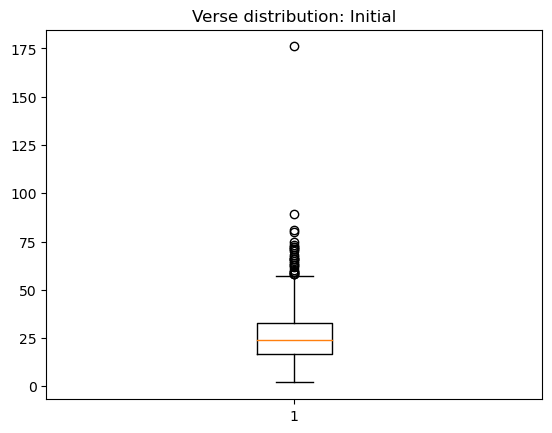

In [4]:
plt.boxplot(bible_df['verse'])
plt.title('Verse distribution: Initial')

In [5]:
# Filter large chapters with many verses

MAX_VERSE_THRESHOLD = 100

filtered_df = bible_df[bible_df['verse'] > MAX_VERSE_THRESHOLD]

# Create a new DataFrame to store the split rows
new_rows = []

# Iterate through each row in the filtered DataFrame
for index, row in filtered_df.iterrows():
    book_id = row['book_id']
    chapter = row['chapter']
    verse_count = row['verse']
    
    # Split the verse count into chunks
    chunk_num = 0
    while verse_count > MAX_VERSE_THRESHOLD:
        new_rows.append({'book_id': book_id, 'chapter': chapter, 'chunk': chunk_num, 'verse': MAX_VERSE_THRESHOLD})
        verse_count -= MAX_VERSE_THRESHOLD
        chunk_num += 1
    
    # Add the remaining verse count as a new row
    new_rows.append({'book_id': book_id, 'chapter': chapter, 'chunk': chunk_num, 'verse': verse_count})

# Append the new rows to the original DataFrame
bible_df = bible_df.append(new_rows, ignore_index=True)
    
# Remove the original rows
bible_df = bible_df[~(bible_df['verse'] > MAX_VERSE_THRESHOLD)]

In [6]:
# Sort dataframe

def custom_sort_key(book_id):
    book_map = {book: index for index, book in enumerate(book_order)}
    return book_map.get(book_id, 0)  # Default to 0 if book_id not found in dictionary

# Apply the custom_sort_key function to create a new sorting key column
bible_df['book_id_sort_key'] = bible_df['book_id'].apply(custom_sort_key)

# Sort the DataFrame first by 'book_id_sort_key', then by 'chapter' and 'chunk'
bible_df = bible_df.sort_values(by=['book_id_sort_key', 'chapter', 'chunk'])

# Drop the temporary sorting key column
bible_df.drop(columns=['book_id_sort_key'], inplace=True)

Text(0.5, 1.0, 'Verse distribution: After chunking')

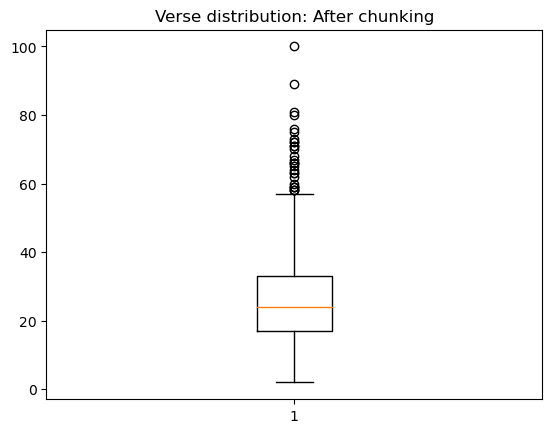

In [7]:
plt.boxplot(bible_df['verse'])
plt.title('Verse distribution: After chunking')

In [8]:
bible_dict = bible_df.to_dict('records')

In [9]:
# Some stats

days = int(365 * (6/7))
print(f"Number of days (w/ weekly day-off): {days}")

total_verses = bible_df['verse'].sum()
print(f"Total verses in Bible: {total_verses}")

total_chapters = len(bible_dict)
print(f"Total chapters in Bible: {total_chapters}")

verses_per_day = int(total_verses / days)
print(f"Verses per day: {verses_per_day}")

chapters_per_day = int(total_chapters / days)
print(f"Chapters per day: {chapters_per_day}")

Number of days (w/ weekly day-off): 312
Total verses in Bible: 31102
Total chapters in Bible: 1190
Verses per day: 99
Chapters per day: 3


In [10]:
# Tune parameter to adjust duration of plan

verses_per_day = 100

In [11]:
# Iteration 1: Split chapters directly by day

bible_splits = np.array_split(bible_dict, days)
sum_list = []

for item in bible_splits:
    summ = 0
    for verse in item:
        summ += verse['verse']
    sum_list.append(summ)
    
assert len(sum_list) == days

Text(0.5, 1.0, 'Verses per day: Split by chapter')

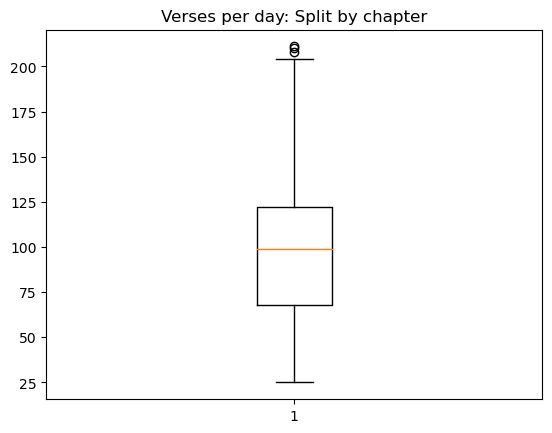

In [12]:
plt.boxplot(sum_list)
plt.title('Verses per day: Split by chapter')

In [13]:
# Iteration 2: Split chapters by verse count as close as possible to daily average

bible_splits = [list(i) for i in bible_splits]
bible_splits_sum = [{'split': split, 'sum': sum_list[index]} for index, split in enumerate(bible_splits)]

bible_split = []
bible_split_indexes = []

for curr_ind, curr_chapter in enumerate(bible_dict):
    #print("= = = = = = = = = = = = = = = =")
    #print(curr_ind)
    #print(bible_split)
    #print(bible_split_indexes)
    if curr_ind not in bible_split_indexes:
        curr_split = [curr_chapter]
        bible_split_indexes.append(curr_ind)

        for next_ind, next_chapter in enumerate(bible_dict[curr_ind + 1:]): # loop through all subsequent chapters
            curr_split_verse_sum = sum([i['verse'] for i in curr_split])
            next_split = curr_split + [bible_dict[curr_ind + next_ind + 1]]
            next_split_verse_sum = sum([i['verse'] for i in next_split])
            #print(curr_ind + next_ind + 1)
            if curr_ind + next_ind + 1 == len(bible_dict) - 1: # for last chapter in list, close out
                #print("Reached last item")
                bible_split.append(curr_split)
                break
            elif (next_split_verse_sum - verses_per_day > verses_per_day - curr_split_verse_sum):
                # if next split verse count diff from average is larger than previous split
                #print("Too many new verses - stop adding chapters")
                bible_split.append(curr_split)
                #print(bible_split)
                break # do not add split, keep current_split as is and exit
            else:
                #print(f"Add another split with index {curr_ind + next_ind + 1}")
                #print(f"next_split: {next_split_verse_sum - verses_per_day} - curr_split: {verses_per_day - curr_split_verse_sum}")
                bible_split_indexes.append(curr_ind + next_ind + 1)
                curr_split = next_split
                continue # Add another split
    #else:
        #print(f"Chapter index {curr_ind} skipped")

In [14]:
print(f"{len(bible_split)} splits/days generated")

314 splits/days generated


In [15]:
# Count verses for plotting

verse_sums = []
for i in bible_split:
    summ = sum([j['verse'] for j in i])
    verse_sums.append(summ)

Text(0.5, 1.0, 'Verses per day: Split by verse count')

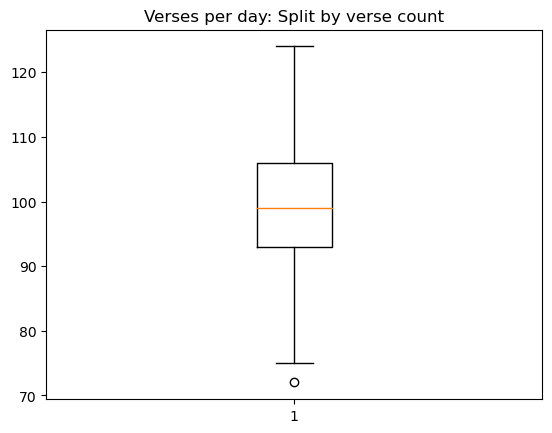

In [16]:
plt.boxplot(verse_sums)
plt.title('Verses per day: Split by verse count')

In [17]:
bible_split

[[{'book_id': 'Gen', 'chapter': 1, 'chunk': 0, 'verse': 31},
  {'book_id': 'Gen', 'chapter': 2, 'chunk': 0, 'verse': 25},
  {'book_id': 'Gen', 'chapter': 3, 'chunk': 0, 'verse': 24},
  {'book_id': 'Gen', 'chapter': 4, 'chunk': 0, 'verse': 26}],
 [{'book_id': 'Gen', 'chapter': 5, 'chunk': 0, 'verse': 32},
  {'book_id': 'Gen', 'chapter': 6, 'chunk': 0, 'verse': 22},
  {'book_id': 'Gen', 'chapter': 7, 'chunk': 0, 'verse': 24},
  {'book_id': 'Gen', 'chapter': 8, 'chunk': 0, 'verse': 22}],
 [{'book_id': 'Gen', 'chapter': 9, 'chunk': 0, 'verse': 29},
  {'book_id': 'Gen', 'chapter': 10, 'chunk': 0, 'verse': 32},
  {'book_id': 'Gen', 'chapter': 11, 'chunk': 0, 'verse': 32}],
 [{'book_id': 'Gen', 'chapter': 12, 'chunk': 0, 'verse': 20},
  {'book_id': 'Gen', 'chapter': 13, 'chunk': 0, 'verse': 18},
  {'book_id': 'Gen', 'chapter': 14, 'chunk': 0, 'verse': 24},
  {'book_id': 'Gen', 'chapter': 15, 'chunk': 0, 'verse': 21},
  {'book_id': 'Gen', 'chapter': 16, 'chunk': 0, 'verse': 16}],
 [{'book_id':